In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize': (18, 10)})

In [2]:
event_data = pd.read_csv('./data/event_data_train.csv')
submissions_data = pd.read_csv('./data/submissions_data_train.csv')

In [3]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')

In [4]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [5]:
event_data['day'] = event_data.date.dt.date
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [6]:
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<AxesSubplot:xlabel='day'>

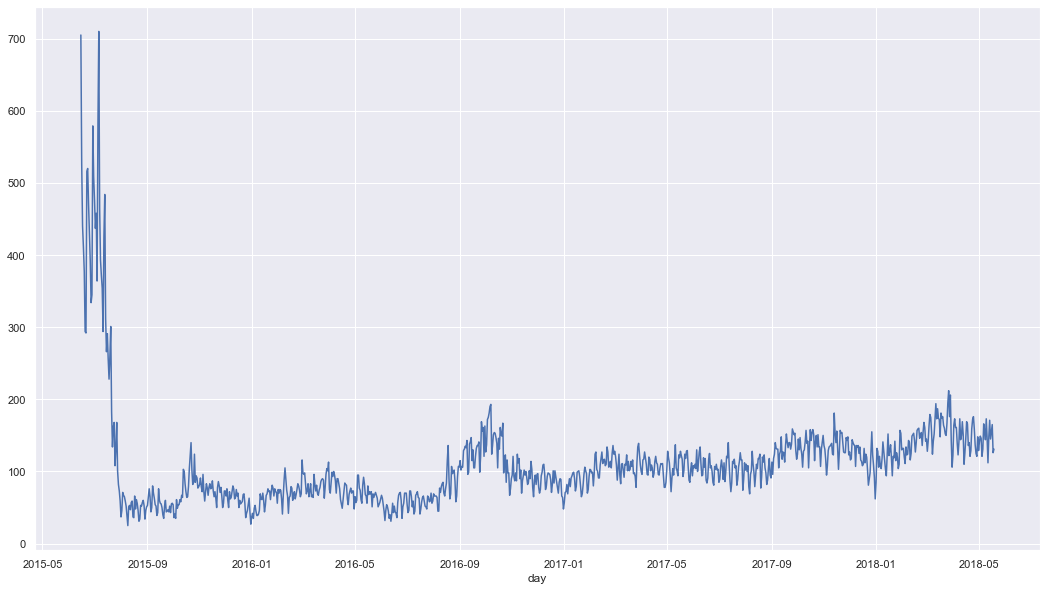

In [7]:
event_data.groupby('day').user_id.nunique().plot()

In [8]:
users_events_data = event_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                       fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [9]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [10]:
# Отобрать уникальные таймы каждого пользователя. Если один уникальный тайм - один день и тп.
# diff считает разность между ближайшими значениями сдева направа - [1,2,5] = [1,3](1-2=1)
gap_data = event_data[['user_id','day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

gap_data = pd.Series(np.concatenate(gap_data, axis=0)) #axis=0 - строки
gap_data = gap_data / (24 * 60 * 60) # разница в днях в перерывах между заходом на курс

<AxesSubplot:>

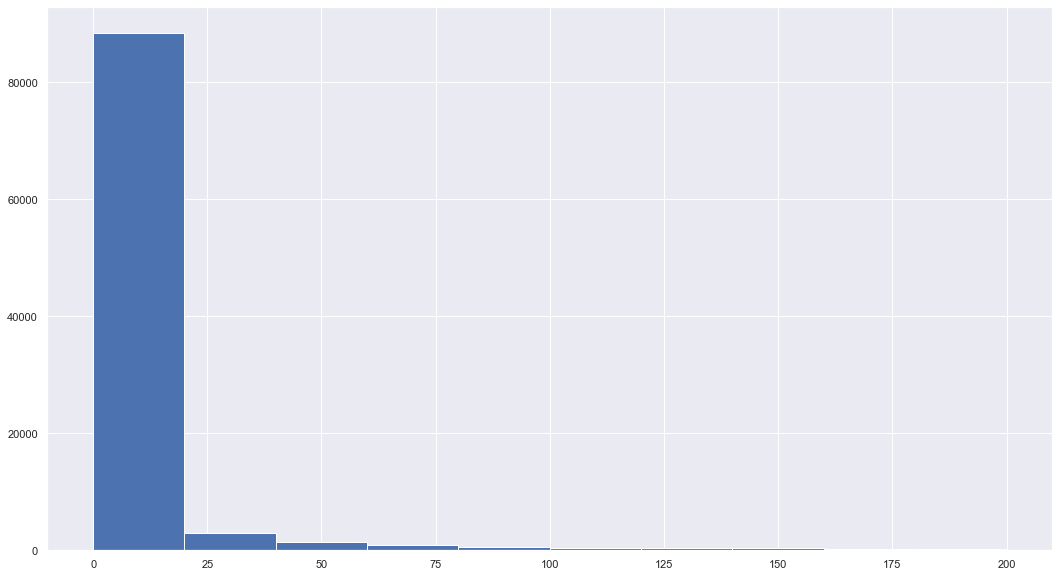

In [11]:
gap_data[gap_data < 200].hist()

In [12]:
gap_data.quantile(.90) # только 10 процентов вернулись спустя 18 дней

18.325995370370403

In [13]:
now = 1526772811
drop_out = 2592000

In [14]:
users_data = event_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})

In [15]:
# Если разность текущего времени и последнего посещения больше 30ти дней - кикнулся
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [16]:
#outer нужен что бы пользователи с нолями попыток тоже попали в фрейм. fillna заполнить NaN 0
users_data = users_data.merge(users_scores, how='outer').fillna(0)
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [17]:
users_days = event_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [18]:
users_data = users_data.merge(users_days, how='outer')

In [19]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [21]:
users_data.groupby('passed_course').count()
# 100 * 1425 / 17809 примерно 8 процентов прошло курс

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
